# 1. Importing packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/ofa-ai-mastery-computer-vision'

# 2. Visualising data

In [4]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,dog,900
1,cat,700
2,deer,600
3,horse,600


<Axes: xlabel='Name of class', ylabel='Number of samples'>

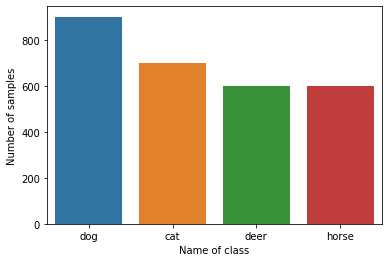

In [5]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

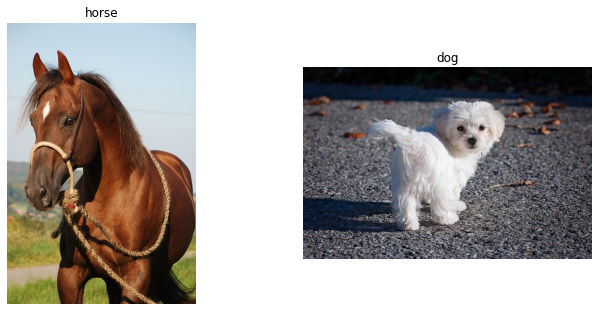

In [6]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(2):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,5)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [7]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [8]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=32)

val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=32 )

Found 2240 images belonging to 4 classes.
Found 560 images belonging to 4 classes.


# 4. Building the model

In [9]:
# i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

In [10]:

checkpoint_filepath = '/content/drive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 4)                 2

# 5. Training and evaluating

In [11]:
# model.load_weights(checkpoint_filepath)
# model.load_weights bisa di jalankan saat runtime google colabs ter restart

history = model.fit(train_ds , batch_size=32,  validation_data = val_ds , epochs = 20, callbacks=[model_checkpoint_callback])

Epoch 1/20
70/70 [==============================] - 73s 829ms/step - loss: 0.8584 - accuracy: 0.6857 - val_loss: 0.4526 - val_accuracy: 0.8607
Epoch 2/20
70/70 [==============================] - 69s 985ms/step - loss: 0.3233 - accuracy: 0.9134 - val_loss: 0.2755 - val_accuracy: 0.9143
Epoch 3/20
70/70 [==============================] - 61s 878ms/step - loss: 0.2299 - accuracy: 0.9268 - val_loss: 0.2389 - val_accuracy: 0.9214
Epoch 4/20
70/70 [==============================] - 73s 1s/step - loss: 0.1891 - accuracy: 0.9362 - val_loss: 0.1881 - val_accuracy: 0.9357
Epoch 5/20
70/70 [==============================] - 57s 812ms/step - loss: 0.1479 - accuracy: 0.9540 - val_loss: 0.1709 - val_accuracy: 0.9446
Epoch 6/20
70/70 [==============================] - 68s 978ms/step - loss: 0.1250 - accuracy: 0.9634 - val_loss: 0.1530 - val_accuracy: 0.9482
Epoch 7/20
70/70 [==============================] - 67s 966ms/step - loss: 0.1078 - accuracy: 0.9714 - val_loss: 0.1524 - val_accuracy: 0.9393
Ep



*   dengan batch size = 32, epochs = 15, maka training accuracy = 99,37%
*   dengan batch size = 32, epochs = 18, maka training accuracy = 99,11%

*   dengan batch size = 32, epochs = 18 dan menambahkan 2 dense layer, maka training accuracy = 99,11%

*   dengan batch size = 32, epochs = 15, dan learning_rate=0.0003, maka training accuracy = 97,63%

*   dengan optimezer = adam, batch size = 32, epochs = 15, dan learning_rate=0.0005, maka training accuracy = 95%











18/18 [==============================] - 10s 559ms/step - loss: 0.1347 - accuracy: 0.9536


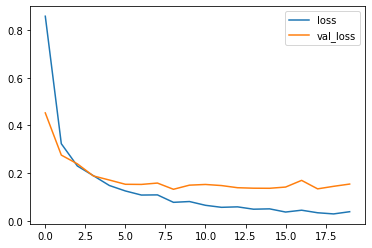

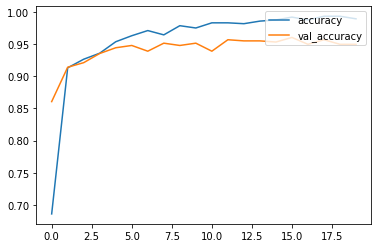

In [12]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

dengan batch size = 32, epochs = 15, maka hasil evaluasi accuracy = 95,89% (ini pelatihan kedua karna runtime disconnect, menunjukkan penurunan)

dengan batch size = 32, epochs = 15, maka hasil evaluasi accuracy = 95,54%

dengan batch size = 32, epochs = 15 dan menambah 2 dense layer, maka hasil evaluasi accuracy = 94,82%

dengan batch size = 32, epochs = 15, dan learning_rate=0.0003, maka maka hasil evaluasi accuracy = 95,36%

dengan optimezer = adam, batch size = 32, epochs = 15, dan learning_rate=0.0005, maka maka hasil evaluasi accuracy = 77%

# 6. Preparing for submission

In [18]:
sub_csv ='/content/drive/MyDrive/ofa-ai-mastery-computer-vision/Sample_submission.csv'
path_test = '/content/drive/MyDrive/ofa-ai-mastery-computer-vision/test /test'

In [19]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [20]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 0s 40ms/step


In [22]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
5,6,1
6,7,3
7,8,0
8,9,3
9,10,2


In [24]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)